## Classification of Environmental Sound using Deep Learning

In [19]:
print('[INFO] import necessary packages')
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
import numpy as np
import os
import cv2
import imutils
from imutils import paths
%matplotlib inline
import numpy as np
import pandas as pd
import random
from scipy.io import wavfile
from sklearn.preprocessing import scale
import librosa.display
import librosa
import matplotlib.pyplot as plt
import os

[INFO] import necessary packages


In [20]:
class FCHeadNet:
    def build(baseModel, classes, D):
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(D, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(classes, activation="softmax")(headModel)
        return headModel

In [21]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
    # store the image data format
        self.dataFormat = dataFormat
    def preprocess(self, image):
    # apply the Keras utility function that correctly rearranges the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

In [22]:
from keras.preprocessing.image import img_to_array
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat
    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

In [23]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter
    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [24]:
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors
        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
        # load the image and extract the class label assuming that our path has the following format:/path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)
            data.append(image)
            labels.append(label)
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))
        return (np.array(data), np.array(labels))

In [25]:
print("[INFO] loading images...")
location = "/data"
imagePaths = list(paths.list_images(location))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

[INFO] loading images...


In [26]:
print('[INFO] initiating preprcessors')
sp = SimplePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

[INFO] initiating preprcessors
[INFO] processed 500/2600
[INFO] processed 1000/2600
[INFO] processed 1500/2600
[INFO] processed 2000/2600
[INFO] processed 2500/2600


# transfer learning and fine tuning
## load the VGG16 architecture from disk using the supplied, pre-trained ImageNet weights

[INFO] training head...
Train on 1950 samples, validate on 650 samples
Epoch 1/25
1950/1950 [==============================] - 25s 13ms/step - loss: 4.6070 - acc: 0.0241 - val_loss: 3.8880 - val_acc: 0.0523
Epoch 2/25
1950/1950 [==============================] - 24s 12ms/step - loss: 3.9015 - acc: 0.0354 - val_loss: 3.7605 - val_acc: 0.0831
Epoch 3/25
1950/1950 [==============================] - 24s 12ms/step - loss: 3.7715 - acc: 0.0585 - val_loss: 3.6439 - val_acc: 0.1000
Epoch 4/25
1950/1950 [==============================] - 24s 12ms/step - loss: 3.6554 - acc: 0.0687 - val_loss: 3.5026 - val_acc: 0.1446
Epoch 5/25
1950/1950 [==============================] - 24s 12ms/step - loss: 3.5421 - acc: 0.0856 - val_loss: 3.4038 - val_acc: 0.1692
Epoch 6/25
1950/1950 [==============================] - 24s 12ms/step - loss: 3.4533 - acc: 0.0985 - val_loss: 3.2187 - val_acc: 0.1615
Epoch 7/25
1950/1950 [==============================] - 24s 13ms/step - loss: 3.4232 - acc: 0.1149 - val_loss: 3.

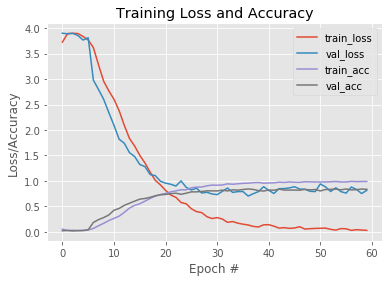

In [27]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)


baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# initialize the new head of the network, a set of FC layersfollowed by a softmax classifier
headModel = FCHeadNet.build(baseModel, len(classNames), 256)
 #place the head FC model on top of the base model -- this willbecome the actual model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

opt = RMSprop(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
 #train the head of the network for a few epochs (all other layers are frozen) -- this will allow the new FC layers
 #start to become initialized with actual "learned" values versus pure random
print("[INFO] training head...")
model.fit(trainX, trainY, batch_size=32,validation_data=(testX, testY), epochs=25, verbose=1)

print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classNames))

for layer in baseModel.layers[13:]:
    layer.trainable = True

print("[INFO] re-compiling model...")
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set of CONV layers along with our set of FC layers
print("[INFO] fine-tuning model...")
H = model.fit(trainX, trainY, batch_size=32,validation_data=(testX, testY), epochs=60, verbose=1)
model.save('ecs50_model.h5')
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classNames))

#visualisation 
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 60), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
         
